# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `<30>`
* Students: `<Tapparel Joachim, Tuuva Tim, Buchegger Anael, Biotto Lucas>`
* Dataset: `<Music Archive>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = np.load('../data/fma_metadata/adjacency.npy') # the adjacency matrix

# We don't want to have any isolated node so we need to remove them!
# Remove line full of 0
adjacency = adjacency[~np.all(adjacency == 0, axis=1)]

# Remove column full of 0
adjacency = adjacency.T[~np.all(adjacency.T == 0, axis=1)]

n_nodes = adjacency.shape[0]  # the number of nodes in the network

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
D = np.diag(sum(adjacency)) #We put the degrees on the diagonal of a matrix full of zeros, this creates the matrix D. 

#We compute the inverse of the D matrix and then put it to the square in order to have 
#D^(-1/2) for the normalisation of the Laplacian
Dinv = np.linalg.inv(D)
Dinvsquare = Dinv**(1/2)

#We just create the combinatorial and the normalized Laplacian following the lecture given in class
laplacian_combinatorial = D-adjacency
laplacian_normalized = Dinvsquare@laplacian_combinatorial@Dinvsquare

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
#We give a correct name and we store both of the Laplacian in CSR format
laplacian_comb =  sparse.csr_matrix(laplacian_combinatorial)
laplacian_norm = sparse.csr_matrix(laplacian_normalized)

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [6]:
#Computation of the eigenvector and eigenvalues of the combinatorial Laplacian with a dense reprentation (with "toarray")
w1, v1 = np.linalg.eigh(laplacian_comb.toarray())

#Computation of the eigenvector and eigenvalues of the normalized Laplacian with a dense reprentation (with "toarray")
w2, v2 = np.linalg.eigh(laplacian_norm.toarray())

#We associate the eigenvector and the eigenvalues with a correct name
eigenvectors_comb = v1
eigenvalues_comb =  w1

#We associate the eigenvector and the eigenvalues with a correct name
eigenvectors_norm = v2
eigenvalues_norm =  w2

#Assertions in order to check if the matrixs of the eigenvectors have the correct size 
assert eigenvectors_comb.shape == (n_nodes, n_nodes)
assert eigenvectors_norm.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Here, we take the eigensolver "np.linalg.eigh()" because we want to have all the the eigenvectors and the eigenvalues of our Laplacian Graph (we could have used the same kind of eigensolver given by scipy but that wouldn't have changed anything). We use this eigensolver because we have a symmetric matrix and we want the eigenvalues in an ascending order. We could have used an eigensolver for sparse matrix like "scipy.sparse.eigs" but in that case we don't compute all the eigenvectors and the eigenvalue. We will use this kind of eigensolver in the next section.**

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**S is the incidence matrix.$S^\top x$ compute the gradient of the function x**

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

Since L is positive semidefinite by construction, we can decompose it as
\begin{align}
&\ \ \  L=u\Lambda u^\top &\text{with $\Lambda$ a diagonal matrix of eigenvalues of L and u a matrix composed of the corresponding eigenvectors}\\
&\Leftrightarrow u^\top L u=\Lambda\\
&\Leftrightarrow u_k^\top L u_k=\lambda_k &\text{with $\lambda_k $ the kth element on the diagonal of $\Lambda$ and $u_k$ the kth row of u}\\
\end{align}
We then have
\begin{align}
\lambda_k&=u_k^\top Lu_k \\
&=u_k^\top S S^\top u_k &\text{since $L=S S^\top$}\\
&=(S^\top u_k)^\top S^\top u_k \\
&=||S^\top u_k||_2^2
\end{align}

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

$$\| S^\top x \|_2^2=\sum_{i\ne k}(x[i]-x[k])^2$$

**It gives a mesure of the amount of variation of the signal x**

### Question 5

What is the value of $u_1$, both for the combinatorial and normalized Laplacians?

**u1 is the eigenvector corresponding to the first eigenvalue, it contains a one for each node inside the first component. The multiplicity of the eigenvalue 0 gives us the number of components in our graph**

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

Text(0.5, 1.0, 'Spectrum of the Normalized Laplacian')

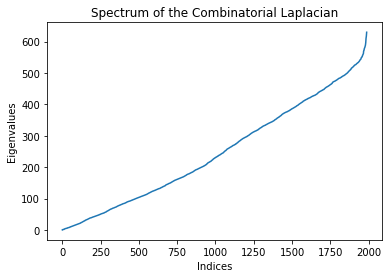

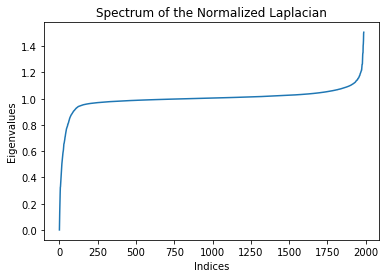

In [7]:
#We just plot our eigenvalues for the combinatorial Laplacian
plt.figure(0)
plt.plot(eigenvalues_comb)
plt.xlabel('Indices')
plt.ylabel('Eigenvalues')
plt.title('Spectrum of the Combinatorial Laplacian')

#We just plot our eigenvalues for the normalized Laplacian
plt.figure(1)
plt.plot(eigenvalues_norm)
plt.xlabel('Indices')
plt.ylabel('Eigenvalues')
plt.title('Spectrum of the Normalized Laplacian')

**We observe that the spectrum correctly represents that the eigenvalues are in ascending order for both representations. For the eigenvalues of the combinatorial Laplacian, we can see that the spectrum is pratically linear until the end where it seems to increase a lot. This is what we can expect from a classical graph. For the eigenvalues of the normalized Laplacian, we can see that we have a pratically flat line around 1. This effect clearly represent the effect of the normalisation.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [8]:
eigenvalues_comb

array([9.04022226e-14, 5.17538088e-01, 7.60845879e-01, ...,
       6.17433661e+02, 6.22270637e+02, 6.29875861e+02])

In [9]:
eigenvalues_norm

array([1.31565359e-16, 1.03689567e-01, 1.34046698e-01, ...,
       1.44232593e+00, 1.49718882e+00, 1.50624569e+00])

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**We can see that in our eigenvalues_comb vector we have just one value which is nearly zero ($\lambda_{1}=9.04022226\cdot10^{-14}$). As the next eigenvalue is far from zero, we can assume that there's only one zero in our eigenvalues vector so there is only one connected component. For the normalized Laplacian, we can see in the eigenvalues_norm that we have again only one value which is nearly zero ($\lambda_{1}=1.31565359\cdot10^{-16}$) so as we have already seen with the combinatorial Laplacian, there's only one connected component in our graph. Just by looking at the biggest eigenvalue for both of the combinatorial and normalized Laplacian, we can see that in that specific case we have an upper bound. But in fact, we can see that for both of the combinatorial and the normalized Laplacian, the eigenvalues seems to increase a lot when we reach the bigger eigenvalues so we can assume that in a realistic case we don't have an upper bound for this kind of graph. More precisely, we assume that with some other data but the same kind of graph, we could reach some eigenvalues which are bigger than the one we get here.**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.


**Information : For the next steps, we will only use the normalized Laplacian because we find it better for our graph (after testing).**

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**We use Laplacian eigenmaps in order to have a visualisation of our graph. With the Laplacian eigenmaps we can have a 2D representation of our graph or a 3D representation wich can show some properties like the clusters or some other propreties (like the density of our graph, an idea of the number of element in our graph, etc). We can even use graph embedding just in order to extract some properties we didn't expect, without even making any visualisation (4D or more for example).**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [10]:
#First we check if have only one connected component as have seen in the point six
import networkx as nx

nx.is_connected(nx.from_numpy_matrix(adjacency))

True

In [11]:
#As we only have one connected component we can now recompute the eigenvectors with eigensolver for the sparse 
#matrix (in order to have a faster computation).
#We only need the first three eigenvectors because we want d=2 dimension and the first eigenvector doesn't respect 
#the condition for the Laplacian eigenmaps (it's the constant eigenvector which give any information).

eigenvalue, eigenvector = scipy.sparse.linalg.eigsh(laplacian_norm, 3, which='SM')


Z = np.zeros((n_nodes,2)) #initialisation of the vector
Z_norm = np.zeros((n_nodes,2)) #initialisation of the vector

#Here we just put the eigenvectors in the correct form
Z[:,0] = eigenvector[:,1]
Z[:,1] = eigenvector[:,2]

#Here we just put the eigenvectors in the correct form with the normalisation
Z_norm[:,0] = Dinv@eigenvector[:,1]
Z_norm[:,1] = Dinv@eigenvector[:,2]

eigenvector

array([[-0.02955804, -0.02228828, -0.00677481],
       [-0.00807062,  0.01254169, -0.00068499],
       [-0.00673896,  0.01577473, -0.00092779],
       ...,
       [-0.02293324, -0.03345108, -0.00370468],
       [-0.01477623, -0.00250787, -0.00504764],
       [-0.03019375,  0.01828035, -0.00763341]])

Plot the nodes embedded in 2D. Comment on what you see.

Text(0.5, 1.0, 'Laplacian eigenmaps for the normalized eigenvector and the normalized Laplacian')

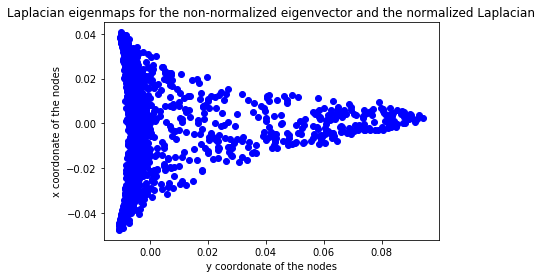

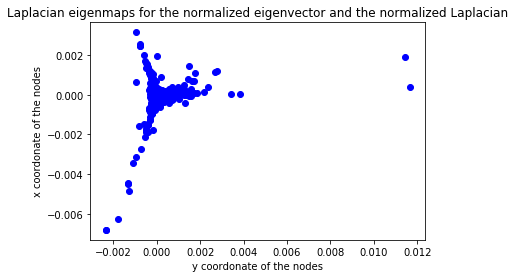

In [12]:
plt.figure(0)
plt.plot(Z[:,1],Z[:,0],'bo') #We invert the x and y data in order it look like what we get in the milestone 1 (with gephi)
plt.xlabel('y coordonate of the nodes')
plt.ylabel('x coordonate of the nodes')
plt.title('Laplacian eigenmaps for the non-normalized eigenvector and the normalized Laplacian')

plt.figure(1)
plt.plot(Z_norm[:,1],Z_norm[:,0],'bo')
plt.xlabel('y coordonate of the nodes')
plt.ylabel('x coordonate of the nodes')
plt.title('Laplacian eigenmaps for the normalized eigenvector and the normalized Laplacian')

**We can clearly see two parts in our embedded graph. A compact part on one side and a more expanded one on the other. These two parts can indicate that we have two clusters which is what we expect to get because we have rock and hip-hop tracks in our case, we will see in the next section if these clusters really are what we expect. If we compare with what we get with Gephi in the first milestone, we can clearly see the similarity. We can see that in our case, we have better results with the non-normalized eigenvectors.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**It preserves the distance between the nodes. As we preserve the distance between the nodes, we also preserve the cluster that we can get with the kMeans algorithm (see next section).**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**As we have seen before, we only kept two genres in our graph, we therefore should have two clusters in our graph so we chose k=2. Then we chose to take d=2 too because we want to see the result on a 2D embedded graph. As we have already done all the calculations for the embedding in 2D in question 8, we will simply use what we got for the embedding graph.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [13]:
#For the first point, as we have already done the embedding in 2D in the question 8, we will directly use this one.
#We have seen that the embedding with non-normalized eigenvector is better than the one with normalized eigenvector so
#we choose to keep the first one.

#For the second point, we can directly use the embedding as Z. As we chose to have d=2, we will not only use the fiedler
#vector but also the third eigenvector so we can directly take the Z created in the question 8.


Kmeans = KMeans(n_clusters=2,random_state=0).fit(Z) #We use directly the KMeans given by scikit-learn

cluster = Kmeans.labels_


#Here we have tried to compute the clusters with the Fiedler vector :

#cluster = np.zeros(n_nodes)

#for i in range(0,n_nodes):
#    if eigenvector[i,1] < 0:
#        cluster[i] = 0
#    else:
#        cluster[i] = 1

We tried to partition with the Fiedler Vector but the partitioning resulting from it divides our data horizontally around 
zero, having no correlation whatsoever with our real clusters. Therefore we chose to use the kMeans algorithm in order 
to have a more coherent result (even if we have k=2).

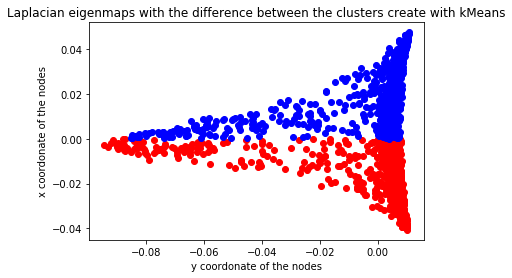

In [14]:
from IPython.display import Image
Image("./fiedler_plot.png",width=500)

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [15]:
n_cluster = 0

#We first compute the number of element in the cluster numbered "0"
for i in range(0,(n_nodes)):
    if cluster[i]==0:
        n_cluster=n_cluster+1

#We create some new variable for the reorder of our elements
adjacency_reorder = adjacency.copy()   
cluster_reorder = cluster.copy()
Z_reorder = Z.copy()
 
#We initiate some variable in order to count the number of element which are not in the good place
k1=0
k2=0

#We initiate some variable in order to register the indices of the element which are not at the good place
#The size of this element should be large enough in case that all the element check are not at the good place
IndDiffClust1 = np.zeros(n_cluster,dtype=int)
IndDiffClust2 = np.zeros(n_nodes-n_cluster,dtype=int)
 
#We assume that the n_cluster first element of our cluster vector are in the cluster numbered "0". 
#We check here each element for the cluster numbered "0". The number of element which are not at the 
#good place in this first n_cluster element is the same than the number of element which are not at 
#the good place in the last part of the cluster vector. We register here the indices of the elements 
#which are not at the right place using the incrementation of k1.
for i in range(0,(n_cluster)):
    if cluster[i]!=0:
        IndDiffClust1[k1] = i
        k1 = k1+1

#Here we check the last part of the cluster vector. If the elements are not in the cluster "1", we count 
#it and register the indices of the element using the incrementation of k2.
for i in range(n_cluster,n_nodes):
    if cluster[i]!=1:
        IndDiffClust2[k2] = i
        k2 = k2+1

#Now that we have the indices of the element which are not correclty placed for both of the clusters,
#we can swap the vector associated and then the element are correctly placed.
for i in range(0,k1):
    adjacency_reorder[IndDiffClust1[i],:] = adjacency[IndDiffClust2[i],:]
    adjacency_reorder[IndDiffClust2[i],:] = adjacency[IndDiffClust1[i],:]
    
    adjacency_reorder[:,IndDiffClust1[i]] = adjacency[:,IndDiffClust2[i]]
    adjacency_reorder[:,IndDiffClust2[i]] = adjacency[:,IndDiffClust1[i]]
    
    cluster_reorder[IndDiffClust1[i]] = cluster[IndDiffClust2[i]]
    cluster_reorder[IndDiffClust2[i]] = cluster[IndDiffClust1[i]]
    
    Z_reorder[IndDiffClust1[i],:] = Z[IndDiffClust2[i],:]
    Z_reorder[IndDiffClust2[i],:] = Z[IndDiffClust1[i],:]
    

In [16]:
n_cluster  #number of elements in the cluster numbered "0"

1772

In [17]:
n_nodes-n_cluster  #number of elements in the cluster numbered "1"

216

In [18]:
k1 #k1 is the number of elements to swap for the cluster numbered "0"

206

In [19]:
k2 #k2 is the number of elements to swap for the cluster numbered "1"

#k1 and k2 should be the same as we swap the element which are not correct for the cluster "0"
#with the element which are not correct for the cluster "1". This is what we see here.

206

**For this part, we expected to have two clusters with pratically the same size (as we have around 1000 rock elements and 1000 Hip-Hop ones). But in fact, we can clearly see here that we have one big cluster and another very small one in comparison. We will explain why we don't have what we expected in the next question. For the moment we can see that the 2D embedding of our graph is in fact really dense even if two parts seem to appear.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [20]:
#As we register the Hip-Hop node on the first half of the adjacency matrix and the Rock node on the second half, we will check the number of nodes which are not
#correctly placed assuming first that the Hip_Hop is the cluster "0" and the Rock is the cluster "1" and then assuming the 
#inverse (Hip-Hop is the cluster "1" and Rock is the cluster "0").

k_HH1R0 = 0  #Counter of elements which are not in correct cluster for Hip-Hop associated to cluster "1" and Rock to cluster "0"
k_HH0R1 = 0  #Counter of elements which are not in correct cluster for Hip-Hop associated to cluster "0" and Rock to cluster "1"

n_half = int(n_nodes/2)  #Index of the half of the graph

#Counting the number of element in the wrong cluster for Hip-Hop when it is associated to the cluster "1"
for i in range(0,n_half):
    if cluster[i]!=1:
        k_HH1R0 = k_HH1R0+1
        
#Counting the number of element in the wrong cluster for Rock when it is associated to the cluster "0"       
for i in range(n_half,n_nodes):
    if cluster[i]!=0:
        k_HH1R0 = k_HH1R0+1
        
#Counting the number of element in the wrong cluster for Hip-Hop when it is associated to the cluster "0"      
for i in range(0,n_half):
    if cluster[i]!=0:
        k_HH0R1 = k_HH0R1+1
        
#Counting the number of element in the wrong cluster for Rock when it is associated to the cluster "1"         
for i in range(n_half,n_nodes):
    if cluster[i]!=1:
        k_HH0R1 = k_HH0R1+1
        
p_HH1R0 = k_HH1R0/n_nodes*100 #compute the percent of error for Hip-Hop associated to cluster "1" and Rock to cluster "0"
p_HH0R1 = k_HH0R1/n_nodes*100 #compute the percent of error for Hip-Hop associated to cluster "0" and Rock to cluster "1"

In [21]:
p_HH1R0

45.67404426559356

In [22]:
p_HH0R1

54.32595573440644

**We see that the associated cluster should be Hip-Hop to cluster "1" and Rock to cluster "0" in our case. We almost have the maximum possible errors. We can thus assume that the clusters we get are not correlated to the genre. In fact, as we already said, the nodes of our graph are too close and we can't see correctly the clusters associated to the genre of the musics with this kind of algorithm and this number of dimensions. Our graph is thus too dense to correctly use the KMeans algorithm. 
Plotting the 2D embedding with a separation between the genres, we can see that the nodes associated to each genre are too close to have a correct use of the kMeans algorithm, even if we can observe below that there seems to be a difference between the genres in the 2D embedded graph.**

Text(0.5, 1.0, 'Laplacian eigenmaps with the difference between the genres')

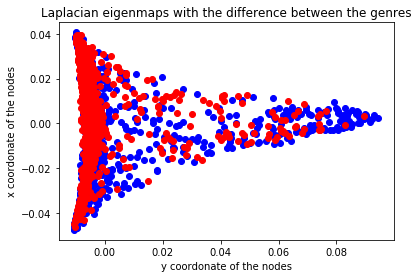

In [23]:
plt.figure(3)
plt.plot(Z[:n_half,1],Z[:n_half,0],'bo') #Hip-Hop part draw in blue
plt.plot(Z[n_half:,1],Z[n_half:,0],'ro') #Rock part draw in red
plt.xlabel('y coordonate of the nodes')
plt.ylabel('x coordonate of the nodes')
plt.title('Laplacian eigenmaps with the difference between the genres')

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

Text(0.5, 1.0, 'Laplacian eigenmaps with the difference between the clusters create with kMeans')

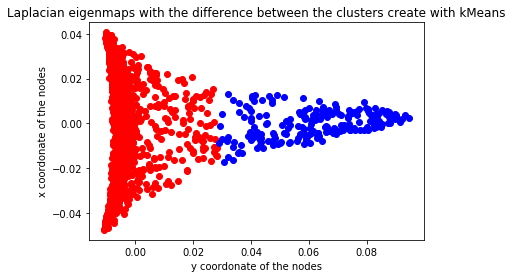

In [24]:
#As we have create a reorder Z (called Z_reorder) with the n_cluster first element in the cluster "0" and the other element 
#in the cluster "1", we can directly use this "Z_reorder" in order to assign one color per cluster.

plt.figure(4)
plt.plot(Z_reorder[:n_cluster,1],Z_reorder[:n_cluster,0],'ro') #plot the cluster "0" in red as the Rock before
plt.plot(Z_reorder[n_cluster:,1],Z_reorder[n_cluster:,0],'bo') #plot the cluster "1" in blue as the Hip-Hop before
plt.xlabel('y coordonate of the nodes')
plt.ylabel('x coordonate of the nodes')
plt.title('Laplacian eigenmaps with the difference between the clusters create with kMeans')

**As expected kMeans found a separation between the two principal clusters, unfortunately they don't directly correspond to the two genres but one cluster contains a subset of hip-hop and the other one contains all the rock and the rest of hip-hop**

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**We use the eigenvectors of the Laplacian because the Laplacian and its eigenvectors give informations about the variations in the graph. With this representation of the distances, we can hope to find the real clusters. We could have directly used the distances computed in milestone 1 in order to find the clusters. We can also, and probably should, do some combining operations between the features to add dimensions and to better isolate the real clusters.**